In [1]:
import pickle
from functools import partial
from math import pi
from pathlib import Path

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd
from scipy.optimize import newton_krylov

from tqdm import tqdm_notebook as tqdm

from pybem.core import Airfoil, Propeller

In [2]:
################################################################################
path_polar = Path(r'../data/naca2415_extended.csv')

airfoil_data_df = pd.read_csv(path_polar.open(mode='r')) 
airfoil_data_df = airfoil_data_df.astype(float)

alpha    = airfoil_data_df['Alpha'].values
polar_cl = airfoil_data_df['Cl'].values
polar_cd = airfoil_data_df['Cd'].values

airfoil = Airfoil(alpha, polar_cl, polar_cd)
                  

In [57]:
################################################################################

# Create propeller parameters
J   = 0.5
D   = 1.0
N_b = 8

def solidity(r):
    NUM = 2.0 * pi * r * D 
    DEN = N_b * propeller.chord(r)
    return NUM / DEN

def tan_phi(r):
    return J / r

# Create distributions
N = 50
# r_hat = r / D
r_hat = np.linspace(0.25, 0.5, N)
chord = np.linspace(1.0, 0.5, N)

tan0 = np.rad2deg(np.arctan(tan_phi(r_hat[0])))
tanN = np.rad2deg(np.arctan(tan_phi(r_hat[-1])))

print('phi_0', tan0)
print('phi_N', tanN)

twist = np.linspace(tan0, tanN, N) * 1.2

propeller = Propeller(r_hub      = 0.0, 
                      r_tip      = 0.0,
                      r_dist     = r_hat,
                      beta_dist  = twist,
                      chord_dist = chord)

phi_0 63.43494882292202
phi_N 45.0


In [58]:
################################################################################
def residual(theta, r):

    _S = solidity(r)
    
    # Compute base effective pitch
    _tan_phi = tan_phi(r) 
    phi0 = np.rad2deg(np.arctan(_tan_phi))

    # Compute airfoil angle
    _twist = propeller.beta(r)
    _alpha = _twist - (phi0 + theta)
    
    # return phi0, _alpha, _twist

    try:
        _cl = airfoil.cl(_alpha)
        _cd = airfoil.cd(_cl)
    except:
        print('phi0:', phi0)
        print('twist:', _twist)
        print('alpha:', _alpha)
        print('theta:', theta)
        raise ValueError

    _tan_gamma = _cd / _cl

    # Get angles in the right degrees
    _theta = np.deg2rad(theta)
    _phi   = np.deg2rad(phi0 + theta)

    NUM = 1.0 - _tan_gamma   * np.tan(_theta)
    DEN = 4.0 * np.sin(_phi) * np.tan(_theta)

    return _S / _cl - NUM / DEN 

In [59]:
inference_angles = []

for radius in tqdm(r_hat):
    _residual = partial(residual, r = radius)
    inference_angles.append({'r': radius, 'theta': newton_krylov(_residual, 0.5, iter = 1000).item()})

theta_df = pd.DataFrame(inference_angles).set_index('r') 

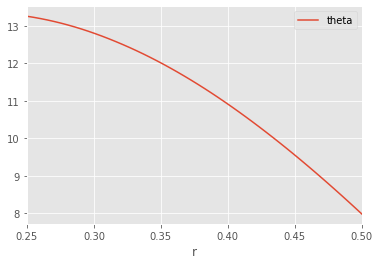

In [60]:
theta_df = pd.DataFrame(inference_angles).set_index('r')

theta_df.plot()

---

In [61]:
def angles_distribution(theta, r):

    _S = solidity(r)
    
    # Compute base effective pitch
    _tan_phi = tan_phi(r) 
    phi0 = np.rad2deg(np.arctan(_tan_phi))

    # Compute airfoil angle
    _twist = propeller.beta(r)
    _alpha = _twist - (phi0 + theta)

    _cl = airfoil.cl(_alpha)
    _cd = airfoil.cd(_cl)

    _tan_gamma = _cd / _cl
    _gamma = np.rad2deg(np.arctan(_tan_gamma))

    # Get angles in the right degrees
    _phi   = phi0 + theta

    return {'twist': _twist, 
            'alpha':_alpha, 
            'phi0': phi0, 
            'phi': _phi, 
            'r': r, 
            'theta': theta, 
            'S_cl': _S / _cl, 
            'gamma': _gamma}

#%%
distributions = []

for radius in theta_df.index:
    distributions.append(angles_distribution(theta_df.loc[radius].values[0], radius))

distributions_df = pd.DataFrame(distributions)
distributions_df = distributions_df.set_index('r')
#%%

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12dcb0668>,
      dtype=object)

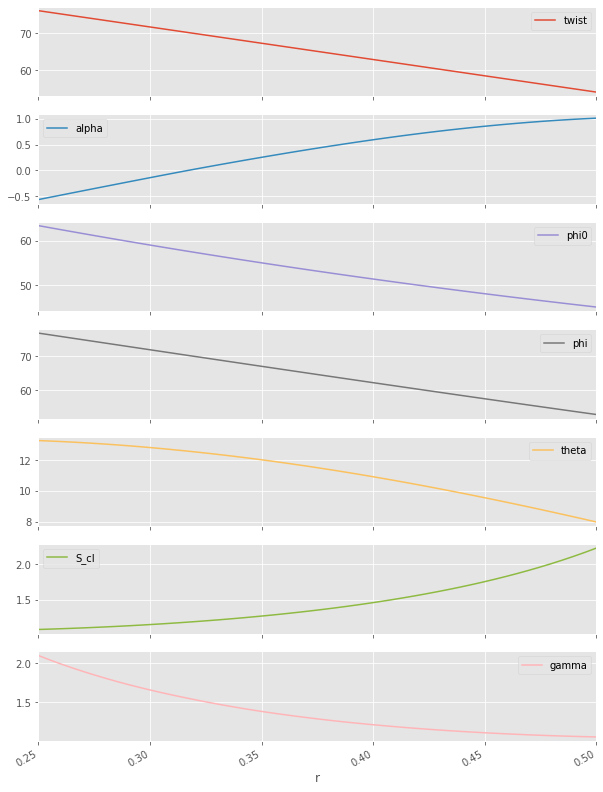

In [62]:
distributions_df.plot(subplots=True, figsize = (10,15))

---

In [63]:
from numpy import tan

In [64]:
def incidence_axial(angles):
    
    phi   = np.deg2rad(angles['phi'])
    phi0  = np.deg2rad(angles['phi0'])
    gamma = np.deg2rad(angles['gamma'])
        
    NUM = tan(phi) * (1.0 + tan(phi0) * tan(phi + gamma))
    DEN = tan(phi0)  * (1.0 + tan(phi) * tan(phi + gamma))
    
    return NUM / DEN - 1.0

In [65]:
def incidence_radial(angles):
    
    phi  = np.deg2rad(angles['phi'])
    phi0 = np.deg2rad(angles['phi0'])
    
    a = incidence_axial(angles)
    
    NUM = tan(phi0) * (1.0 + a)
    DEN = tan(phi)
    
    return 1.0 - NUM / DEN

In [66]:
incidences = []

for angles in distributions:

    a       = incidence_axial(angles)
    a_prime = incidence_radial(angles)
    
    incidences.append({'a':a, 'a_p': a_prime, 'r': angles['r']})

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12cad0048>,
      dtype=object)

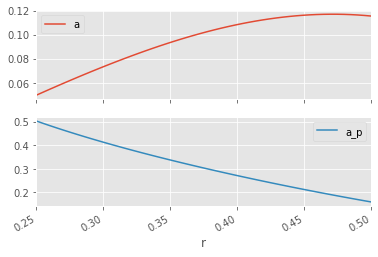

In [67]:
pd.DataFrame(incidences).set_index('r').plot(subplots=True)

---

In [68]:
def K(angles):
    
    _cl = airfoil.cl(angles['alpha'])
    a = incidence_axial(angles)
    
    phi   = np.deg2rad(angles['phi'])
    gamma = np.deg2rad(angles['gamma'])
    
    NUM = _cl * (1.0 + a)**2.0
    DEN = np.sin(phi)**2.0 * np.cos(gamma)
    
    return NUM / DEN

In [69]:
def Tc(angles):
    
    _K = K(angles)
    
    phi   = np.deg2rad(angles['phi'])
    gamma = np.deg2rad(angles['gamma'])
    
    return _K * np.cos(phi + gamma)

In [70]:
def Qc(angles):
    
    _K = K(angles)
    
    phi   = np.deg2rad(angles['phi'])
    gamma = np.deg2rad(angles['gamma'])
    
    return _K * np.sin(phi + gamma)

In [71]:
def dCT_dr(angles):
    
    _r = angles['r']
    
    _c = propeller.chord(_r)
    
    _Tc = Tc(angles)
    
    return _c * _Tc

In [72]:
def dCQ_dr(angles):
    
    _r = angles['r']
    
    _c = propeller.chord(_r)
    
    _Qc = Qc(angles)
    
    return _r * _c * _Qc

In [73]:
dCT_dr(angles)

0.20220748734062266

In [74]:
dCQ_dr(angles)

0.13936514558107332

In [75]:
d_ct = pd.Series()
d_qt = pd.Series()

for angles in tqdm(distributions):
    d_ct.loc[angles['r']] = dCT_dr(angles)
    d_qt.loc[angles['r']] = dCQ_dr(angles)
    

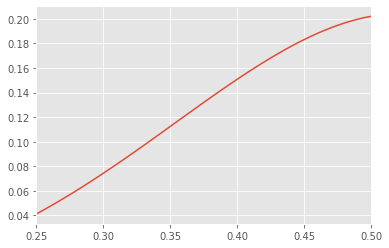

In [76]:
d_ct.plot()

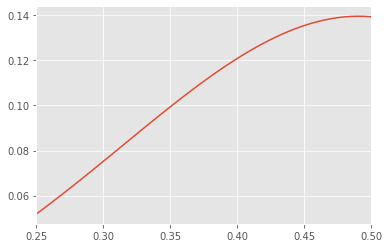

In [77]:
d_qt.plot()

In [78]:
from scipy.integrate import simps


In [79]:
T = pd.Series()
Q = pd.Series()

for element in d_ct.index:
    T.loc[element] = simps(d_ct.loc[:element].values, d_ct.loc[:element].index.values)
    Q.loc[element] = simps(d_qt.loc[:element].values, d_qt.loc[:element].index.values)

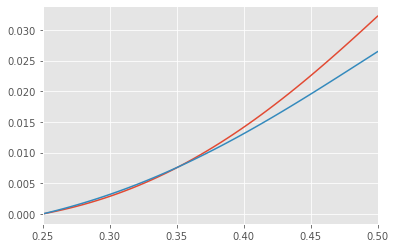

In [80]:
T.plot()
Q.plot()

In [82]:
T.tail(1).values[0]

0.032213533689808706